In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister , Aer, assemble
import numpy as np
from numpy import pi

# we want to first encode the integers. We can generalize this after.
# Figure out how to encode integers.
input_list = [5,7,8,9,1]
output = 16
input_list_len = len(input_list)-1
int_qubits = output.bit_length()

print("bits required to store ", max(input_list), " = ", int_qubits)

q = QuantumRegister(input_list_len)
c = ClassicalRegister(input_list_len)
## we'll manually do it for now just to figure out wtf is going on

# we will do 5 + 7
qc = QuantumCircuit(q, c)
# Create 5
qc.x([q[0], q[2]])
print(qc)

def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# apply qft
circuit = qft(qc, input_list_len)
q2 = QuantumRegister(input_list_len)
circuit.add_register(q2)
circuit.x(q2[0]) # add one
def apply_controlled_phase(circuit):
    """Applies a controlled phase shift to the target qubit"""
    for qubit in range(1,len(q)+1):
        print(qubit)
        print(len(q))
        for idx in range(0, qubit):
            circuit.cp(2*pi/2**(idx+1), q2[idx], q[qubit-1])
       
    return circuit

circuit = apply_controlled_phase(circuit)
# apply next integer to add
#print(circuit)
# apply inverse qft
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

# Apply inverse
circuit = inverse_qft(circuit, input_list_len)
print(circuit)
circuit.measure(q, c)  # Measure the qubits


aer_sim = Aer.get_backend('aer_simulator')

qobj = assemble(circuit, shots=8192)
job = aer_sim.run(qobj)

from qiskit.visualization import plot_histogram
hist = job.result().get_counts()
print(hist)

bits required to store  9  =  5
       ┌───┐
q26_0: ┤ X ├
       └───┘
q26_1: ─────
       ┌───┐
q26_2: ┤ X ├
       └───┘
q26_3: ─────
            
c13: 4/═════
            
1
4
2
4
3
4
4
4
       ┌───────────┐┌─────────┐                                      »
q26_0: ┤ U3(π,0,π) ├┤ P(π/16) ├──■────────────────■──────────────────»
       └─┬────────┬┘└─────────┘  │                │                  »
q26_1: ──┤ P(π/8) ├──────────────┼────────────────┼───────────────■──»
       ┌─┴────────┴┐ ┌────────┐  │                │               │  »
q26_2: ┤ U3(π,0,π) ├─┤ P(π/4) ├──┼────────────────┼───────────────┼──»
       └┬─────────┬┘ └────────┘┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐»
q26_3: ─┤ U2(0,π) ├────────────┤ X ├┤ P(-π/16) ├┤ X ├┤ P(π/16) ├┤ X ├»
       ┌┴─────────┴┐ ┌────────┐└───┘└──────────┘└───┘└─────────┘└───┘»
q27_0: ┤ U3(π,0,π) ├─┤ P(π/2) ├──────────────────────────────────────»
       └─┬────────┬┘ └────────┘                                      »
q27_1: ──┤ P(π/4) ├─────────

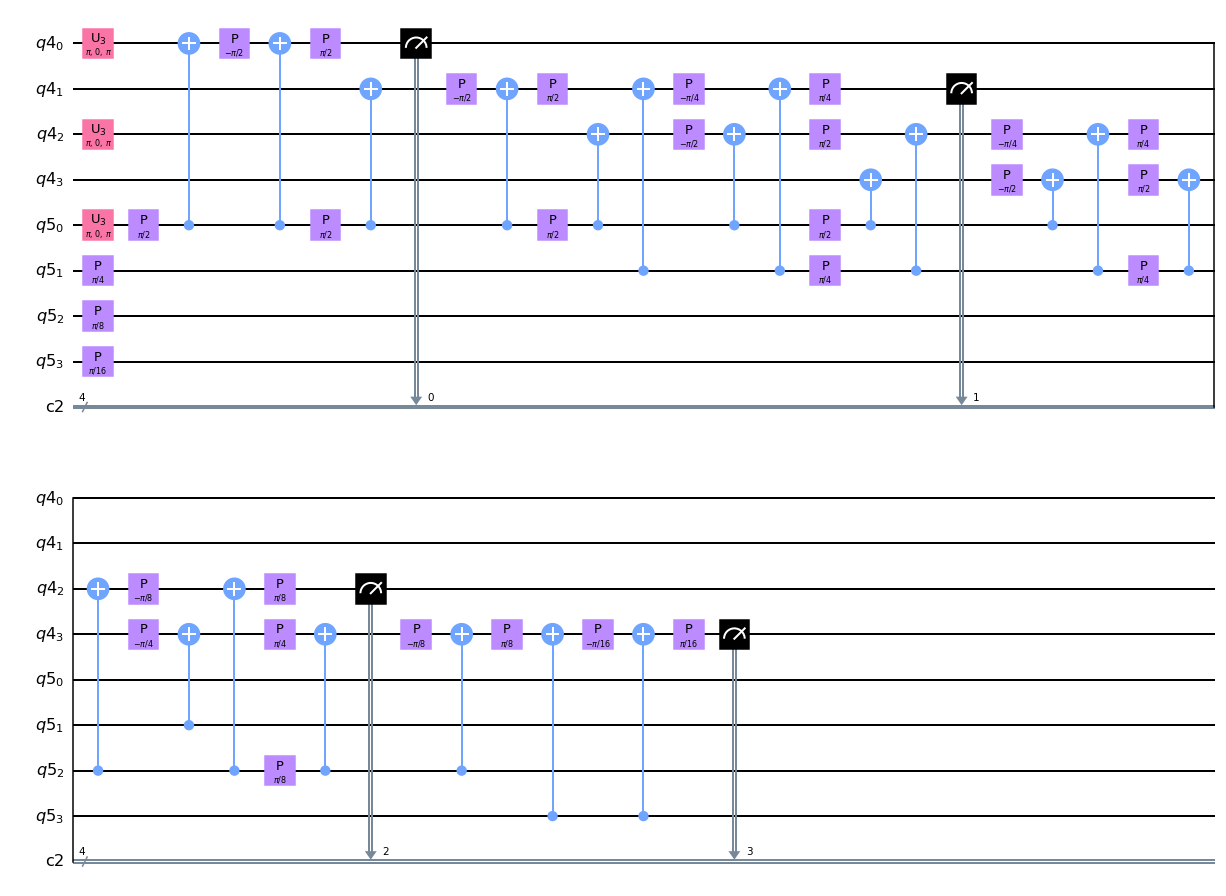

In [5]:
circuit.draw('mpl')